In [64]:
import numpy as np
import numpy.matlib
from scipy.stats import norm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import seaborn as sns

In [65]:
# # %%
# params ={ "mu": 0.1,
#          "sigma": 0.2,
#          "T" : 1}

#%% ANN
class MyNet(nn.Module):
    
    def __init__(self, n ):
        super(MyNet, self).__init__()
        
        # 1 input layer (X_T^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 1 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, 1)
        #self.f_h2_to_out = nn.LogSoftmax(n, 3)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        
        return y
    

In [90]:
params = {
    "S0" : np.array([1]),
    "mu" : np.array([0.03]),
    "sigma" : np.array([.2]),
    "rho" : np.array([[1]]),
    "rf" : 0.00,
    "delta" : np.array([0.7]),
    "T" : 1
    }


def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= params["mu"].shape[0]
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S

In [91]:
#%% Compute RM from samples
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])
    
    # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1        
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.75
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p* alpha* torch.mean(X[X<=LQtl]) \
                        + (1-p) *(1-beta) * torch.mean(X[X>=UQtl] ) )/eta
        
        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [101]:
# %% compute Wasserstein distance
def getWassDistance(X, Y):
    
    # generate co-monotonic versions of the sample
    X_sorted, _ = torch.sort(X)
    Y_sorted, _ = torch.sort(Y)
    
    wass_dist = torch.sqrt(torch.mean(( X_sorted - Y_sorted )**2))
    
    return wass_dist 

# %% simulate and compute RM


def SimRM(net, params, Nsims, type="alpha-beta"):
    
    # a sample sim
#     X = np.exp((params["mu"]-0.5*params["sigma"]**2)*params["T"]\
#                +params["sigma"]*np.sqrt(params["T"])*np.random.randn(Nsims,1))
    
#     X_t = torch.tensor(X, dtype=torch.float, requires_grad=False)
    
#     Y_t = net(X_t)
    Ndt=500
    T =5
    t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False)
       
    w_t = net(S_t)    
    Y_t = w_t[-1,:].reshape(-1,1)
    X_t = S_t[-1,:].reshape(-1,1)
    
    wass_dist = getWassDistance(X_t, Y_t)
    
    RiskMeasure = GetRiskMeasure(Y_t, "alpha-beta") 
    
    return RiskMeasure, wass_dist, X_t, Y_t

In [93]:
Nsims = 20
X = np.exp((params["mu"]-0.5*params["sigma"]**2)*params["T"]
           +params["sigma"]*np.sqrt(params["T"])*np.random.randn(Nsims,1))
    
X_t = torch.tensor(X, dtype=torch.float, requires_grad=False)

Y_t = net(X_t)

In [94]:
Y_t.shape

torch.Size([20, 1])

In [ ]:
Ndt=500
T =5
t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
X_t = torch.tensor(S, dtype=torch.float, requires_grad=False)

Y_t = net(X_t)    

In [98]:
Y_t.shape

torch.Size([501, 20, 1])

In [99]:
Y_T = Y_t[-1,:].reshape(-1,1)

In [100]:
Y_T.shape

torch.Size([20, 1])

In [97]:
wass_dist = getWassDistance(X_t, Y_t)

RiskMeasure = GetRiskMeasure(Y_t, "alpha-beta") 

In [102]:
# %%
def PlotHists(X, Y):
    
    bins = np.linspace(0,2.5,25)
    
    Xcp = X.clone().detach().numpy()
    Ycp = Y.clone().detach().numpy()
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,3,1)
    
    sns.distplot(Xcp, bins = bins, hist=True, kde=True, label='Index')
    sns.distplot(Ycp, bins = bins,  hist=True, kde=True, label='Portfolio')
    plt.legend()    
    
    plt.axvline(np.quantile(Xcp, 0.15),color='k')
    plt.axvline(np.quantile(Ycp, 0.15),color='r')

    plt.xlim(bins[0],bins[-1])
    
    plt.legend()
    
    plt.subplot(1,3,2)
    sns.distplot(Ycp-Xcp, hist=True, kde=True)
    plt.axvline(np.quantile(Ycp-Xcp, 0.05),color='k')

    
    plt.subplot(1,3,3)
    
    plt.plot(np.array([0,bins[-1]]),np.array([0,bins[-1]]))
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    
    plt.ylim(0.9*np.quantile(Xcp,0.01),1.1*np.quantile(Xcp,0.99))
    plt.xlim(0.9*np.quantile(Xcp,0.01),1.1*np.quantile(Xcp,0.99))

    
    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)
    
    plt.tight_layout()
    
    plt.show()

In [103]:
    
#%%
def PlotStrat(net):
 
    X = np.linspace(0.5,2.2,100).reshape(-1,1)
    
    # don't think we need sensitivities w.r.t. this as they are fixed per simulation
    X_t = torch.tensor(X, dtype=torch.float, requires_grad=True)
    
    Y_t = net(X_t)    
    
    Y = Y_t.detach().numpy()
    
    plt.plot(X,Y)
    plt.plot(X,X,'--k',linewidth=0.5)
    
    plt.show()
    
#%%

D:\Anaconda\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


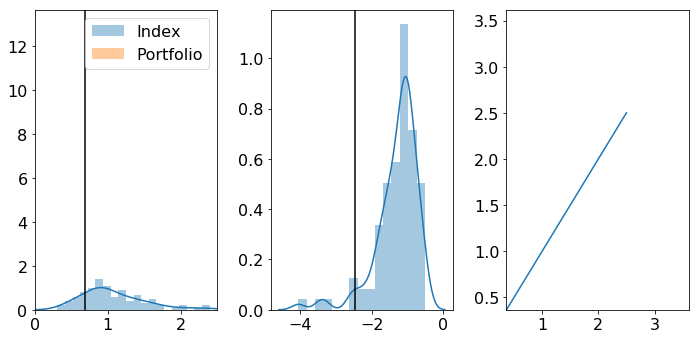

400 Wass Dist: 0.078905396 Risk Measure: -1.0433924 Loss: 9.478303909301758


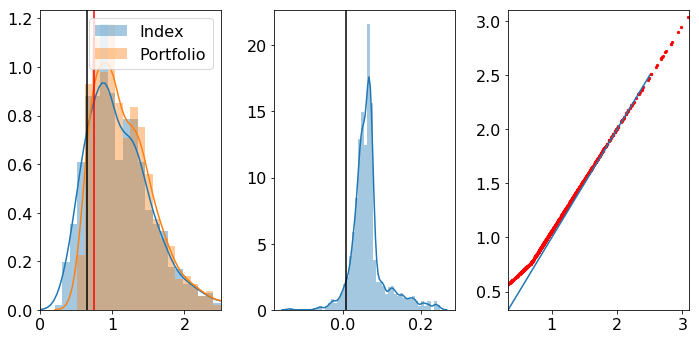

In [ ]:
net = MyNet(10)
RiskMeasure, wass_dist, X_t, Y_t = SimRM(net, params, Nsims=100)
PlotHists(X_t, Y_t)

# create  optimizer
optimizer = optim.Adam(net.parameters())

Nepochs = 5000
loss_hist = []
risk_history = []
wass_dist_history=[]

for epoch in range(Nepochs):  # loop over the dataset multiple times


    # zero the parameter gradients
    optimizer.zero_grad()

    RiskMeasure, wass_dist,  X_t, Y_t = SimRM(net, params, Nsims=1000)
    
    
    loss = 10*wass_dist*(wass_dist>0.1) \
        + RiskMeasure/2 \
        + 10*(torch.mean(Y_t)>torch.mean(X_t))
     
    
    loss.backward()   
    
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.detach().numpy() )
    wass_dist_history.append( wass_dist.detach().numpy() )
    
    # PlotHists(X_t, Y_t)
    
    # plot output every 50 iterations
    if( (epoch % 400 == 0) and (epoch>1) ):
        print(epoch, end=" ")
        print("Wass Dist:", wass_dist.detach().numpy(), end=" " )
        print("Risk Measure:", RiskMeasure.detach().numpy(), end=" ")
        print("Loss:", loss.item())

        PlotHists(X_t, Y_t)
        
        # plt.figure(figsize=(10,5))
        
        # plt.subplot(1,3,1)
        # plt.plot(risk_history)
        # plt.title("RM") 
        
        # plt.subplot(1,3,2)
        # plt.plot(wass_dist_history)
        # plt.title("WD") 
        
        # plt.subplot(1,3,3)
        # plt.plot(loss_hist)
        # plt.title("Loss") 

        # plt.tight_layout()        
        # plt.show()
        

print('Finished Training')